# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [380]:
import pandas as pd

In [381]:
data = pd.read_csv('train.csv')

In [382]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [383]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [384]:
train.isna().sum()

id             0
keyword       44
location    1760
text           0
target         0
dtype: int64

In [385]:
test.isna().sum()

id            0
keyword      17
location    773
text          0
target        0
dtype: int64

In [386]:
train = train.fillna("")

In [387]:
test = test.fillna("")

In [388]:
print(train.isnull().any().any())
print(test.isnull().any().any())

False
False


## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?
2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [389]:
for i in train.target.unique():
    print(i, '  ', train.target[train.target == i].count())
print(train.target.mean())

0    3024
1    2305
0.43253893788703324


В обучающей выборке доля класса "1" равна 0.4, вполне равномерное распределение классов.

In [390]:
k = [(train.keyword[train.keyword == i].count(), i) for i in train.keyword.unique()]

In [391]:
tenkey = [i[1] for i in sorted(k, reverse = True)[1:11]]

In [392]:
for i in tenkey:
    print(i, '  ', train.target[train.keyword == i].mean())

damage    0.4722222222222222
siren    0.11428571428571428
wreckage    1.0
fatalities    0.48484848484848486
deluge    0.16129032258064516
twister    0.1
tsunami    0.3333333333333333
refugees    0.5666666666666667
nuclear%20reactor    0.4
harm    0.13333333333333333


Мне кажется, на столбчатой диаграмме распределение нагляднее

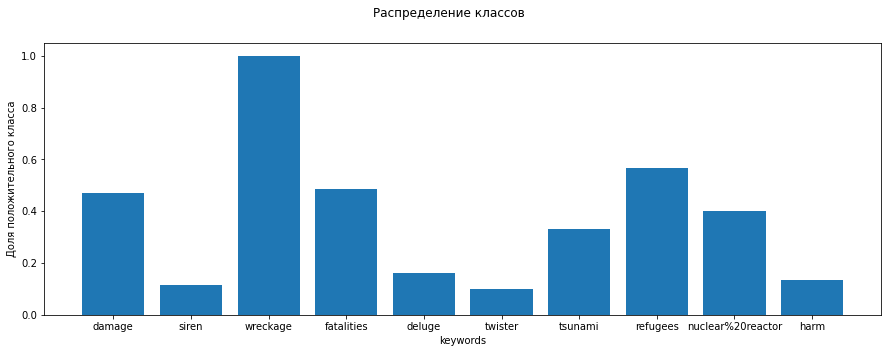

In [393]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(15, 5))
plt.suptitle('Распределение классов')

x = tenkey
y = [train.target[train.keyword == i].mean() for i in x]
plt.bar(x, y)

plt.xlabel('keywords')
plt.ylabel('Доля положительного класса')
plt.show()

Можно посмотреть и на ступенчатой.

C:\Users\asus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


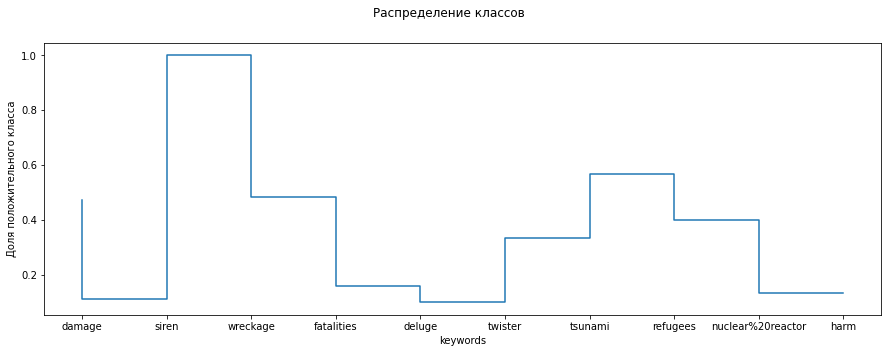

In [394]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.subplots(figsize=(15, 5))
plt.suptitle('Распределение классов')

x = tenkey
y = [train.target[train.keyword == i].mean() for i in x]
sns.lineplot(x,y, drawstyle='steps-pre')

plt.xlabel('keywords')
plt.ylabel('Доля положительного класса')
plt.show()

Наблюдаем неравномерное распределение классов по колонке keyword. Например, wreckage включает только положительные классы, а siren, twister, harm имеет только около 10% объектов положительного класса.

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [395]:
train['text'] = train['keyword'].str.cat(train['location'], sep =" ").str.cat(train['text'], sep =" ")

In [396]:
train = train[['text', 'target']]

In [397]:
train.head()

,text,target
1186,bridge%20collapse Ashes 2015: AustraliaÛªs c...,0
4071,"hail Carol Stream, Illinois GREAT MICHIGAN TEC...",1
5461,police Houston CNN: Tennessee movie theater s...,1
5787,rioting Still rioting in a couple of hours le...,1
7445,wounds Lake Highlands Crack in the path where ...,0


In [398]:
test['text'] = test['keyword'].str.cat(test['location'], sep =" ").str.cat(test['text'], sep =" ")
test = test[['text', 'target']]
test.head()

,text,target
2644,destruction So you have a new weapon that can...,1
2227,deluge The f$&amp;@ing things I do for #GISHW...,0
5448,police UK DT @georgegalloway: RT @Galloway4May...,1
132,aftershock Aftershock back to school kick off...,0
6845,"trauma Montgomery County, MD in response to tr...",0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [399]:
X_train = train.text
y_train = train.target

In [400]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
X_train = vec.fit_transform(X_train)

In [401]:
X_train.shape

(5329, 18455)

получилась матрица размера 5329 * 18455.

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [402]:
list(vec.vocabulary_.items()) #посмотрим на словарь

[('bridge', 2948),
 ('20collapse', 320),
 ('ashes', 1928),
 ('2015', 295),
 ('australia', 2059),
 ('ûªs', 18425),
 ('collapse', 3914),
 ('at', 1977),
 ('trent', 16483),
 ('among', 1628),
 ('worst', 17813),
 ('in', 8314),
 ('history', 7773),
 ('england', 5722),
 ('bundled', 3085),
 ('out', 11995),
 ('for', 6503),
 ('60', 755),
 ('http', 7970),
 ('co', 3861),
 ('t5trhjuau0', 15733),
 ('hail', 7420),
 ('carol', 3363),
 ('stream', 15419),
 ('illinois', 8249),
 ('great', 7206),
 ('michigan', 10594),
 ('technique', 15888),
 ('camp', 3261),
 ('b1g', 2147),
 ('thanks', 16013),
 ('to', 16272),
 ('bmurph1019', 2753),
 ('hail_youtsey', 7421),
 ('termn8r13', 15949),
 ('goblue', 7088),
 ('wrestleon', 17848),
 ('oaskgki6qj', 11648),
 ('police', 12634),
 ('houston', 7933),
 ('cnn', 3854),
 ('tennessee', 15932),
 ('movie', 10940),
 ('theater', 16025),
 ('shooting', 14647),
 ('suspect', 15632),
 ('killed', 9246),
 ('by', 3150),
 ('di8elzswnr', 4890),
 ('rioting', 13800),
 ('still', 15357),
 ('couple', 

In [403]:
def dict_analysis(l: list):
    c = 0
    for word in l:
        if word[0].isnumeric():
            c += 1
        elif not word[0].isalpha():
            i = 0
            flag = False
            while i < len(word[0]) and not flag:
                if word[0][i].isnumeric():
                    flag = True
                    c += 1
                else:
                    i += 1
    print('Кол-во слов с цифрами:', c)  
    
    c = 0
    for word in l:
        if not word[0].isalnum():
            c += 1
    print('Кол-во слов с символами пунктуации:', c)
    
    c = 0
    for word in l:
        if  word[0][0] in ('#', '@'):
            c += 1
    print('Кол-во хэштегов и упоминаний:', c)

In [404]:
dict_analysis(list(vec.vocabulary_.items()))

Кол-во слов с цифрами: 3815
Кол-во слов с символами пунктуации: 315
Кол-во хэштегов и упоминаний: 0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [405]:
X_train = train.text
y_train = train.target

In [406]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

vec = CountVectorizer(tokenizer=TweetTokenizer().tokenize)
X_train = vec.fit_transform(X_train)

In [407]:
dict_analysis(list(vec.vocabulary_.items()))

Кол-во слов с цифрами: 3940
Кол-во слов с символами пунктуации: 7355
Кол-во хэштегов и упоминаний: 3149


Этот токенизатор нам подойдет больше, потому что он предназначен для работы с твитами или сообщениями из соц. сетей. Он сохранил ссылки, хештеги, упоминания, слова (ники) с цифрами и символами пунктуации.

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [551]:
def my_tokenizer(doc):
    #Разобьет текст на токены 
    doc = TweetTokenizer().tokenize(doc.lower())
    #Удалит все токены содержащие не латинские буквы, кроме смайликов и хэштегов
    doc1 = []
    for s in doc:
        if s.isalpha():
            if s[1:].isascii():
                doc1.append(s)
        elif s[0] == '#' and s[1:].isalpha() and s[1:].isascii():
            doc1.append(s)
        elif (s.find('(') != -1 or s.find(')') != -1) and sum([not i.isalpha() for i in s]) == len(s):
            doc1.append(s)
    doc = doc1
    #Удалит стоп-слова
    for s in doc:
        if s in nltk.corpus.stopwords.words('english'):
            doc.remove(s)
    #стемминг
    stemmer = SnowballStemmer('english')
    doc = [stemmer.stem(s) for s in doc]

    return doc

In [561]:
vec1 = CountVectorizer(tokenizer=my_tokenizer)
X10 = vec1.fit_transform(train.text[:10])

In [562]:
list(vec1.vocabulary_.items())

[('bridg', 17),
 ('ash', 10),
 ('australia', 12),
 ('collaps', 26),
 ('trent', 95),
 ('among', 9),
 ('worst', 101),
 ('histori', 46),
 ('england', 33),
 ('bundl', 18),
 ('hail', 43),
 ('carol', 22),
 ('stream', 84),
 ('illinoi', 52),
 ('great', 42),
 ('michigan', 62),
 ('techniqu', 87),
 ('camp', 21),
 ('thank', 89),
 ('#goblu', 0),
 ('#wrestleon', 2),
 ('polic', 70),
 ('houston', 49),
 ('cnn', 25),
 ('tennesse', 88),
 ('movi', 64),
 ('theater', 91),
 ('shoot', 78),
 ('suspect', 86),
 ('kill', 56),
 ('riot', 75),
 ('still', 83),
 ('a', 5),
 ('coupl', 27),
 ('hour', 47),
 ('left', 60),
 ('i', 50),
 ('to', 94),
 ('up', 96),
 ('class', 24),
 ('wound', 102),
 ('lake', 59),
 ('highland', 44),
 ('crack', 28),
 ('the', 90),
 ('path', 68),
 ('wipe', 99),
 ('this', 93),
 ('morn', 63),
 ('beach', 13),
 ('run', 76),
 ('surfac', 85),
 ('elbow', 32),
 ('right', 74),
 ('knee', 58),
 ('airplan', 8),
 ('somewher', 82),
 ('there', 92),
 ('expert', 37),
 ('franc', 39),
 ('begin', 14),
 ('examin', 34),
 

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.
2. Обучите LogisticRegression на полученных признаках.
3. Посчитайте метрику f1-score на тестовых данных.

In [576]:
vec1 = CountVectorizer(tokenizer=my_tokenizer)
vec_train = vec1.fit_transform(train.text)
vec_test = vec1.transform(test.text)

In [577]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

In [580]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(vec_train, y_train)
pred = clf.predict(vec_test)
print(f1_score(test.target, pred))

0.7346491228070176


## Задание 9 (1 балл)

1. Повторите 7 задание, но с tf-idf векторизатором. Как изменилось качество?
2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?
3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [625]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec1 = TfidfVectorizer(tokenizer=my_tokenizer)
vec_train = vec1.fit_transform(train.text)
vec_test = vec1.transform(test.text)

scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

In [626]:
clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(vec_train, y_train)
pred_tfidf = clf.predict(vec_test)
print(f1_score(test.target, pred_tfidf))

0.7479674796747968


Качество модели улучшилось.

In [627]:
vec_train.shape

(5329, 10592)

In [628]:
vec1 = TfidfVectorizer(tokenizer=my_tokenizer, max_df=0.9)
vec_train = vec1.fit_transform(train.text)
vec_test = vec1.transform(test.text)

scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(vec_train, y_train)
pred_tfidf = clf.predict(vec_test)
print(f1_score(test.target, pred_tfidf))

0.7479674796747968


In [629]:
vec_train.shape

(5329, 10592)

Размер матрицы и качество модели не изменились.
Пусть нижняя граница df удет 0.001

In [630]:
vec1 = TfidfVectorizer(tokenizer=my_tokenizer, min_df=0.001, max_df=0.9)
vec_train = vec1.fit_transform(train.text)
vec_test = vec1.transform(test.text)

scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(vec_train, y_train)
pred_tfidf = clf.predict(vec_test)
print(f1_score(test.target, pred_tfidf))

0.748108108108108


In [631]:
vec_train.shape

(5329, 1840)

Даже при небольшом нижнем пороге матрица сильно уменьшилась, потому что встречаемость большинства слов очень мала. Качество улучшилось.

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 7 с HashingVectorizer, укажите количество фичей равное 5000.
2. Какой из подходов показал самый высокий результат?

In [639]:
from sklearn.feature_extraction.text import HashingVectorizer
vec1 = HashingVectorizer(tokenizer=my_tokenizer, n_features=5000)
vec_train = vec1.fit_transform(train.text)
vec_test = vec1.transform(test.text)

In [640]:
scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(vec_train, y_train)
pred_tfidf = clf.predict(vec_test)
print(f1_score(test.target, pred_tfidf))

0.7265877287405813


Неплохой результат, но все-таки лучший результат был при использовании TfidfVectorizer, написанного мною токенизатора и выставленными вручную границами учитываемой встречаемости. 

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [648]:
vec1 = TfidfVectorizer(tokenizer=my_tokenizer, min_df=0.0005, max_df=0.8)
vec_train = vec1.fit_transform(train.text)
vec_test = vec1.transform(test.text)

scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(vec_train, y_train)
pred_tfidf = clf.predict(vec_test)
print(f1_score(test.target, pred_tfidf))

0.7548596112311015


f1 мера 0.755 на тестовых данных. Хороший результат. Использован написанный в задании 7 токенайзер, подобраны параметры min_df=0.0005, max_df=0.8.